# ADAM STRATMAN 
## Code review 2 
## HAS-Tools Fall 2020

### First, we will begin this forecast analysis script by importing the packages needed to run this code. This code is taking flow data generated from the USGS and using it to forecast the streamflow of the Verde River for three different time frames. 

In [1]:
import numpy as np
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import geopandas as gpd
import fiona
import shapely
import matplotlib
from matplotlib.ticker import ScalarFormatter
import contextily as ctx
from shapely.geometry import Point
import geopandas as gpd
import fiona
import matplotlib as mpl
from pyproj import CRS, Transformer
import os


### A little background on this code: It was developed in order to forecast the streamflow of the Verde River based on historical data. It is a linear regression model using historic stream gauge data imported from USGS. Although at certain points it has included other variables to help predict streamflow, this model considers streamflow as the sole data, and has the greatest accuracy. The map below shows where the Verde River is located as well as some other attributes.

![alt text](map.png "Title")



### Next, I am setting up a function to use for my one and two week forecast values. This makes it easier for my forecast script to be used with a correction factor (will explain in greater detail as you get further into this code :) ). Also, you will see the two flow values that need to be manually changed each week. 

In [2]:
last_week_flow = 154.714
last2_week_flow = 126.571


def real_prediction(indexnumber, last_week_flow, last2_week_flow=None):
    ''''
    This function is prepping the linear regression model to be
    multiplied by a correction factor to bring it down to a more
    reasonable value for the forecast of week 1 and week 2.
    '''
    if indexnumber == 0 and last2_week_flow is None:
        rp = (model.intercept_ + model.coef_[indexnumber] * last_week_flow)
    if indexnumber == 1:
        rp = (model2.intercept_ + model2.coef_[0] * last_week_flow +
              model2.coef_[indexnumber] * last2_week_flow)
    if indexnumber != 0 and indexnumber != 1:
        print('The index number =', indexnumber, 'is not valid. Enter 0 or 1.')
    return rp

### Here, I am importing the streamflow data, calling it from the internet. This can be done manually but this method is more efficient for using on a rolling basis. Don't forget to specify the end date! 

In [3]:
# %%
# reading in streamflow data from the internet

url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=09506000&referred_module=sw&period=&begin_date=1989-01-01&end_date=2020-10-19"

# Now we can read it with read_table command the same as we did before
# Note this only works if you select the tab separated data --- try it with table and you will see it doesn't
data2 = pd.read_table(url, skiprows=30, names=['agency_cd', 'site_no',
                                               'datetime', 'flow', 'code'],
                      parse_dates=['datetime'], index_col='datetime')

#separating url onto multiple lines
url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=09506000" \
      "&referred_module=sw&period=&begin_date=1989-01-01&end_date=2020-10-19"

#Replace parts of my url with variables
site = '09506000'
start = '1989-01-01'
end = '2020-11-21'
url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=" + site + \
      "&referred_module=sw&period=&begin_date=" + start + "&end_date=" + end
data2 = pd.read_table(url, skiprows=30, names=['agency_cd', 'site_no',
                                               'datetime', 'flow', 'code'],
                      parse_dates=['datetime'], index_col='datetime')


### Next we need to get this into a format that is easily utilized for extracting the data we are interested in. This is done by converting it into a pandas dataframe. Then, it is further modified to a weekly average logarithmic format rather than a daily format. 

### Also, here you will see the autoregressive model being made. I decided to change my week_values to log_flow values to help improve my model and increase accuracy.

In [4]:
data = pd.read_table(url, sep='\t', skiprows=30,
                     names=['agency_cd', 'site_no', 'datetime', 'flow',
                            'code'],
                     parse_dates=['datetime'])
# Expand the dates to year month day
data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).dayofweek
data['dayofweek'] = pd.DatetimeIndex(data['datetime']).dayofweek

# Aggregate flow values to weekly
flow_weekly = data.resample("W", on='datetime').mean()
flow_weekly.insert(2, 'log_flow', np.log(flow_weekly['flow']), True)

# Setting up the arrays for my model I will use
# This is an autoregressive model that uses two time lags
flow_weekly['log_flow_tm1'] = flow_weekly['log_flow'].shift(1)
flow_weekly['log_flow_tm2'] = flow_weekly['log_flow'].shift(2)

# Here I'm grabbing weeks from 1996-2000 as training dates

train = flow_weekly[370:600][['log_flow', 'log_flow_tm1', 'log_flow_tm2']]
test = flow_weekly[600:][['log_flow', 'log_flow_tm1', 'log_flow_tm2']]

### Here is a visual of what timeframe I am using for training my data, and what the historical behavior of this Verde River streamgage has observed. This also lends insight to how a predictable AR model needs to consider time of year, as you can see the behavior of the river changes with season. While this is shown in a log scale on the y axis, it provides insight into how this river behaves and what part I am training the model with. 

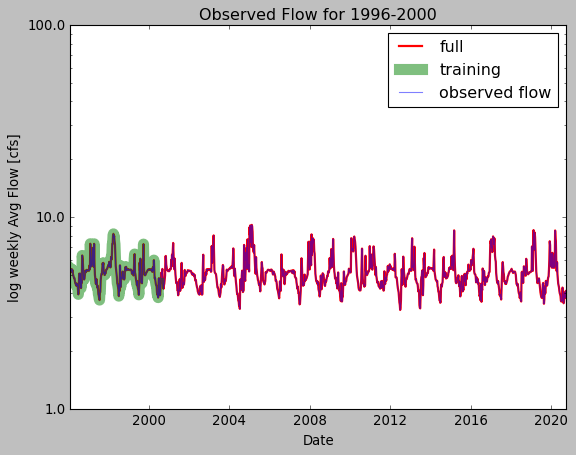

In [5]:

plt.style.use('classic')
fig, ax = plt.subplots()
ax.plot(flow_weekly['log_flow'], 'r', linewidth= 2 ,  label='full')
ax.plot(train['log_flow'], 'g', linewidth=10 , label='training', alpha=.5)
ax.plot(flow_weekly['log_flow'], 'b', label='observed flow', linewidth = 1, alpha = .5)
ax.set(title="Observed Flow for 1996-2000", xlabel="Date", ylabel="log weekly Avg Flow [cfs]",
        yscale='log', xlim=[datetime.date(1996, 2, 4), datetime.date(2020, 10, 3)])
ax.semilogy(range(15))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.legend()
plt.show()


### Now that we have this AR model set up, this next cell will produce my first week forecast for the forecast competition. It will show the model coefficient, slope, and y-intercept. This is important as it shows how accurate you can expect the model to be. 

In [6]:
model = LinearRegression()
x = train['log_flow_tm1'].values.reshape(-1, 1)
y = train['log_flow'].values
model.fit(x, y)

r_sq = model.score(x, y)
print('coefficient of determination:', np.round(r_sq, 2))
print('intercept:', np.round(model.intercept_, 2))
print('slope:', np.round(model.coef_, 2))

# Looking at one week time lag to make prediciton
# Looking at prediction based on previous week
prediction = model.intercept_ + model.coef_ * last_week_flow
print("AR prediciton based on previous week=", prediction.round(2))


coefficient of determination: 0.7
intercept: 0.84
slope: [0.84]
AR prediciton based on previous week= [130.43]


### Now, we will see my forecast prediciton based on two training steps. This is my forecast for the second week of my forecast competition.

In [7]:

# Adding another week to the model (week1, week 2 time lag)
model2 = LinearRegression()
x2 = train[['log_flow_tm1', 'log_flow_tm2']]
model2.fit(x2, y)
r_sq = model2.score(x2, y)
print('coefficient of determination:', np.round(r_sq, 2))
print('intercept:', np.round(model2.intercept_, 2))
print('slope:', np.round(model2.coef_, 2))
# %%
# Using two weeks prior to make prediciton 9/27-10/3
prediction2 = model2.intercept_ + model2.coef_[0] * last_week_flow
+ model2.coef_[1] * last2_week_flow
print("AR prediciton based on previous 2 weeks=", prediction2)

coefficient of determination: 0.7
intercept: 0.82
slope: [0.82 0.02]
AR prediciton based on previous 2 weeks= 127.52148841959036


### Now, I will show my AR forecast along with my predictions outside of the AR forecast. The way my AR forecast values are generated is by using the values of the previous week divided by the forecast for the second week to generate a coefficient by which I can multiply each of my AR forecast values to bring it closer to the true flow. In addition, I add 15 to week 1 and 30 to week 2, as we have been seeing a trend of roughly +20 CFS each week for the last three to four weeks. 

In [8]:

COD = last_week_flow/prediction


my_prediction_1 = real_prediction(0, last_week_flow, None)*COD + 15
my_prediction_2 = real_prediction(1, last_week_flow, last2_week_flow)*COD + 30
print("week 1 prediction outside AR=", my_prediction_1.round(1))
print("week 2 prediction outside AR=", my_prediction_2.round(1))


print("AR prediciton based on previous 1 week=", prediction.round(1))
print("AR prediciton based on previous 2 weeks=", prediction2.round(1))


week 1 prediction outside AR= [169.7]
week 2 prediction outside AR= [184.6]
AR prediciton based on previous 1 week= [130.4]
AR prediciton based on previous 2 weeks= 127.5


### Finally, I will generate a seasonal forecast. This originally was based on minimum flow values from 2019. I have transformed it to use average streamflow data, as it seems we have entered into a "normal" flow based on previous years. This takes the data and puts it into a new dataframe, generates average weekly flow values, and then places it into an array to be used to take the average of two weeks flows starting at 8/15 and going to 12/8. These are general dates based around the weeks we predict in 2020. 

In [9]:

# Redefining the data to be able to look at datetime
data2 = data.copy()
data2['datetime'] = pd.to_datetime(data2['datetime'])
data2 = data2.set_index('datetime')
# Making a new data set to look at weekly average flows for 16 week forecast
data_w = data2.resample("w").mean()

# Pulling out weekly data I will use for the 16 week forecast
seasonal_flow = data_w.loc["2019-8-15":"2019-12-8"]
average_flow = seasonal_flow['flow'].to_list()

# Here I have put the weekly data from the previous cell into an array
# I then averaged the current and proceeding week

weekly_2019_avg = average_flow

forecast_16_week = ((weekly_2019_avg +
                     np.roll(weekly_2019_avg, 1))/2.0)[1::1]
print("These will serve as my 16 week forecast values", forecast_16_week.round(2))





These will serve as my 16 week forecast values [  45.31   37.51   58.35   64.91   55.5    80.73   94.9    88.44   85.94
   83.62   98.91  119.43  130.79  167.29  296.79 1078.64]


### Taking a step back, this graph evaluates how accurate the model is by showing my predictions compared to the true flows over the last 12 weeks.

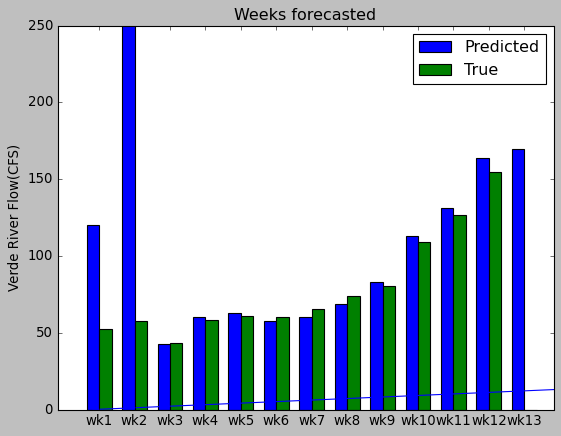

In [10]:

N = 13
my_values = (120, 972, 43, 60, 63, 57.9, 60.4, 68.8, 82.9, 113, 130.9, 163.9, 169.7)
true_values = (52.688, 57.686, 43.229, 58, 60.886, 60.286, 65.7, 73.657, 80.157, 
                  108.971, 126.571, 154.714, 0)

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, my_values, width, label='Predicted')
plt.bar(ind + width, true_values, width,
    label='True')

plt.ylabel('Verde River Flow(CFS)')
plt.title('Weeks forecasted')
plt.xticks(ind + width / 2, ('wk1', 'wk2', 'wk3', 'wk4', 'wk5','wk6', 'wk7', 'wk8', 'wk9', 'wk10','wk11', 'wk12', 'wk13' ))
plt.legend(loc='best')
plt.plot(range(500))

plt.xlim(-1, 13)
plt.ylim(0, 250)
plt.show()

### As you can see from this graph, in the first two weeks my predicitons were very high and not close to the true values. As we move forward into week three and beyond my forecasts were either a little over or under from the true flow. The last three weeks shows me consistently overpredicting the flow. As we have moved into cooler weather and seen some precipitation in the watersheds that feed the Verde, we have seen a steady increase in flow. I have adjusted my model accordingly and hope to forecast closer to true flow values.  